## Homework 4 :  Physics 403, S25
Aidan Meador-Woodruff (ameadorw@ur.rochester.edu)

Due: Friday 28 February, 2025

In [2]:
# Import statements
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy import special 
import timeit

### Problem 1 : Computing a Posterior PDF
*We are given two datasets that have three columns, $x$, $y$, and $\delta y$ for 10 data points. They are a linear model with no intercept, only a slope.*

---
*a).* We first wish to, using a uniform prior, plot the posterior probability density as a function of the slope $m$ to determine which data are more precise.

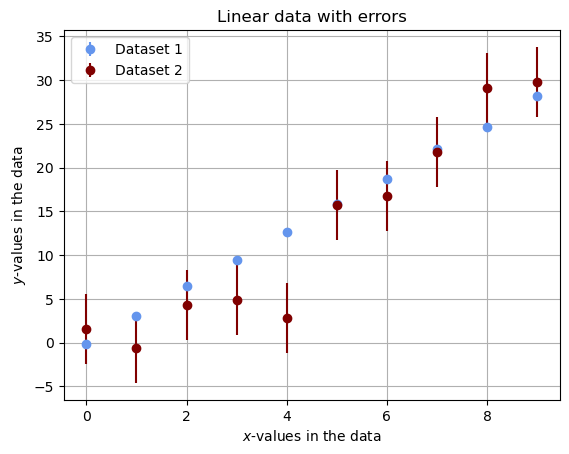

In [3]:
# Importing the two given datasets and plotting them.

data1 = np.loadtxt("HW4/data1.txt").transpose()
data2 = np.loadtxt("HW4/data2.txt").transpose()

plt.errorbar(data1[0],data1[1],yerr=data1[2], fmt='o',color='cornflowerblue',label='Dataset 1');
plt.errorbar(data2[0],data2[1],yerr=data2[2], fmt='o', color='maroon', label='Dataset 2');
plt.grid()
plt.legend()
plt.xlabel(r'$x$-values in the data')
plt.ylabel(r'$y$-values in the data')
plt.title('Linear data with errors');

Roughly eyeballing our data, we expect that the data from dataset 1 to be more precise, due to its significantly smaller error. But, we are well-behaved statisticians, so below we look at the posterior probability density to make sure this is correct.

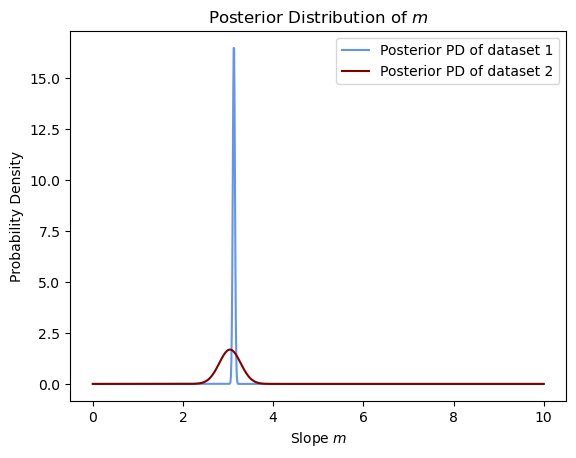

In [4]:
def compute_posterior(x, y, dy, m_values):
    '''
    Function to compute the posterior with given data.
    INPUTS:
    x - the x data [1xN ndarray/list]
    y - the y data [1xN ndarray/list]
    dy - the error in the y data [1xN ndarray/list]
    m_values - the values of the slope m for the posterior [1xM ndarray/list]

    OUTPUT: 
    post - the posterior [1xM ndarray]
    '''
    # Initialize the posterior
    post = []

    for m in m_values:
        # While looping over the ms, compute the likelihood and add to posterior.
        likelihood = np.exp(-0.5 * np.sum(((y - m*x)/dy)**2))
        post.append(likelihood)
        
    post = np.array(post)/np.trapezoid(post,m_values)
    return post 

# Split up our datasets
x1, y1, dy1 = data1[0], data1[1], data1[2]
x2, y2, dy2 = data2[0], data2[1], data2[2]
m_values = np.linspace(0, 10, 1000)

posterior1 = compute_posterior(x1, y1, dy1, m_values)
posterior2 = compute_posterior(x2, y2, dy2, m_values)

plt.plot(m_values, posterior1, label='Posterior PD of dataset 1',color='cornflowerblue')
plt.plot(m_values, posterior2, label='Posterior PD of dataset 2', color='maroon')

plt.xlabel(r"Slope $m$")
plt.ylabel("Probability Density")
plt.title(r'Posterior Distribution of $m$')
plt.legend()
plt.show()

Clearly, our conjecture is correct and the first dataset is more precise due to its far narrower peak.

*b).* Next, we wish to determine the MPV of the posterior PDF and find the confidence intervals to 68% and 90%.

In [15]:
def find_mpv_and_credible_intervals(m_values, posterior, ci_levels=[0.68, 0.90]):
    cumulative_posterior = np.cumsum(posterior) / np.sum(posterior)
    mpv_index = np.argmax(posterior)
    mpv = m_values[mpv_index]
    
    ci_ranges = {}
    for level in ci_levels:
        lower_idx = np.searchsorted(cumulative_posterior, (1 - level) / 2)
        upper_idx = np.searchsorted(cumulative_posterior, 1 - (1 - level) / 2)
        ci_ranges[level] = (m_values[lower_idx], m_values[upper_idx])
    
    return mpv, ci_ranges


mpv1, ci_ranges1 = find_mpv_and_credible_intervals(m_values, posterior1)
mpv2, ci_ranges2 = find_mpv_and_credible_intervals(m_values, posterior2)

print(f"MPV 1: {mpv1:.2f}")
for level, (low, high) in ci_ranges1.items():
    print(f"{int(level*100)}% CI: ({low:.2f}, {high:.2f})")


print(f"MPV 2: {mpv2:.2f}")
for level, (low, high) in ci_ranges2.items():
    print(f"{int(level*100)}% CI: ({low:.2f}, {high:.2f})")


MPV 1: 3.12
68% CI: (3.10, 3.15)
90% CI: (3.09, 3.16)
MPV 2: 3.04
68% CI: (2.80, 3.27)
90% CI: (2.65, 3.43)


*c).* Lastly, we wish to use  a Gaussian prior on $m$ instead. We want to show that if we choose $\mu$ far from the MPV and $\sigma$ sufficiently small, we get a different PDF. The code is below

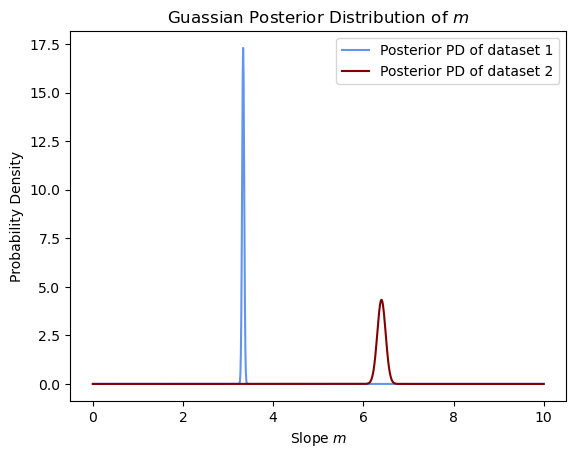

In [24]:
def compute_gaussian_posterior(x, y, dy, m_values, mu, sigma):
    post = []
    for m in m_values:
        likelihood = np.exp(-0.5 * np.sum(((y - m*x)/dy)**2))
        prior = np.exp(-0.5 * ((m - mu) / sigma) ** 2) / (sigma * np.sqrt(2 * np.pi))
        post.append(likelihood * prior)
    post = np.array(post)
    return post / np.trapezoid(post, m_values)  # Normalize

mu_prior = 7  # A number far from 3
sigma_prior = 0.1  # Small sigma
posterior_gaussian1 = compute_gaussian_posterior(x1, y1, dy1, m_values, mu=mu_prior, sigma=sigma_prior)
posterior_gaussian2 = compute_gaussian_posterior(x2, y2, dy2, m_values, mu=mu_prior, sigma=sigma_prior)

plt.plot(m_values, posterior_gaussian1, label='Posterior PD of dataset 1',color='cornflowerblue')
plt.plot(m_values, posterior_gaussian2, label='Posterior PD of dataset 2', color='maroon')

plt.xlabel(r"Slope $m$")
plt.ylabel("Probability Density")
plt.title(r'Guassian Posterior Distribution of $m$')
plt.legend()
plt.show()

Clearly, these are different; both dataset 1 and 2 have a more precise peak but are shifted from their original means.

### Problem 2 : Estimator of a Poisson Mean

*We consider a set of measurements* $\mathbf{x} =\left\{x_i\right\}$ *drawn from a Poisson distribution with mean* $\lambda$.

---
*a).* We wish to find the best estimator of $\hat{\lambda}$ of the mean. The probability of the Poisson distribtuion is
$$P(x_i|\lambda) = \frac{\lambda^{x_i}e^{-\lambda}}{x_i!}$$
The likelihood is therefore the product over all these $i$

$$\mathcal{L}(\lambda) = \prod_{i=1}^n  \frac{\lambda^{x_i}e^{-\lambda}}{x_i!} $$

By noting that an $e^{-\lambda}$ appears in every term and by using exponent rules, we can simplify this to something a bit more palatable 

$$\mathcal{L}(\lambda) = \frac{\lambda^{x_1 + x_2 + \dots x_n}e^{-n\lambda}}{x_1!x_2!\dots x_n!} $$

We take the log of the likelihood to make our lives easier, as the log-likelihood is maximized in the same place as the likelihood. So, we get that 

$$\log \mathcal{L}(\lambda) = \log \left[\frac{\lambda^{x_1 + x_2 + \dots x_n}e^{-n\lambda}}{x_1!x_2!\dots x_n!}\right] = \log \left(\lambda^{x_1 + x_2 + \dots x_n}e^{-n\lambda}\right)  - \log \left(x_1!x_2!\dots x_n!\right)$$

Which can be simplified further as

$$\log \mathcal{L}(\lambda) =  \log \left(\lambda^{x_1 + x_2 + \dots x_n}\right) + \log \left(e^{-n\lambda}\right)  - \log \left(x_1!x_2!\dots x_n!\right)$$

Which is just
$$\log \mathcal{L}(\lambda) =  (x_1 + x_2 + \dots + x_n)\log \left(\lambda\right) - n\lambda  - \log \left(x_1!x_2!\dots x_n!\right)$$

Then, the maximum is where the derivative of this is zero. Differentiating, 

$$\frac{{\rm d}\log \mathcal{L}(\lambda)}{{\rm d}\lambda} = \frac{x_1 + x_2 + \dots + x_n}{\lambda} - n $$

Setting this to zero, we see that this is 

$$n \lambda = \sum_{i}^n x_i$$
Or that 
$$\lambda = \frac{1}{n} \sum_{i}^n x_i$$
Hence, the best estimator of the mean is given by
$$\boxed{\hat{\lambda} = \frac{1}{n}\sum_{i}^n x_i}$$
which is just the actual mean.


*b).* Next, we wish to find the bias of the estimator $\hat{\lambda}$. The bias is just the expectation of the MLE minus the actual parameter. So, this is 

$$b = \langle \hat{\lambda} \rangle - \lambda$$
Expanding,
$$b = \left\langle \frac{1}{n}\sum_{i}^n x_i \right\rangle - \lambda$$
By the linearity of the expectation,
$$b = \frac{1}{n}\sum_{i}^n \langle x_i\rangle - \lambda$$
The expectation of each $x_i$ is just $\lambda$, since they are all from the same Poisson distribution. Hence, we see that
$$b = \frac{1}{n}\sum_{i}^n \lambda - \lambda = 0$$
So, $\hat{\lambda}$ is an unbiased estimator since $\boxed{b=0}$

*c).* Lastly, we wish to find the mean-squared error of $\hat{\lambda}$. This is given by

$$d = \langle (\hat{\lambda} - \lambda)^2 \rangle = {\rm var}(\hat{\lambda}) - b$$

Since the estimator is unbiased, the mean squared error is just the variance of $\hat{\lambda}$. So, this is 

$$d =  {\rm var} \left(\frac{1}{n}\sum_{i}^n x_i\right)$$
By linearity of the variance and by the property that ${\rm var}(ax) = a^2 {\rm var}(x)$, this is 
$$d = \frac{1}{n^2}\sum_{i}^n {\rm var} (x_i)$$
The variance of each individual $x_i$ is $\lambda$, since the distribution is Poisson. Hence, we get that 

$$d = \frac{1}{n^2}\sum_{i}^n \lambda = \frac{1}{n^2} (n\lambda)$$

Therefore, the MSE of $\hat{\lambda}$ is $\boxed{d = \frac{\lambda}{n}}$

### Problem 3 : Estimators of Gaussian Variance
*We consider a Gaussian distribution with $\mu=0$ and $\sigma^2 =1$. Given $N>1$ independent measurements $x_i$ drawn from this distribution, the sample variance $s^2$ can be calculated by* 
$$s^2 = \frac{1}{N-1} \sum_{i=1}^N (x_i - \bar{x})^2$$

---
*a).* Given that $N-1s^2/\sigma^2$ follows a $\chi^2$ distribution with $N-1$ DoF, we first wish to show that $s^2$ is an unbiased estimator of the variance $\sigma^2$ and that 

$${\rm var}(s^2) = \frac{2}{N-1}$$


We begin by noting that a $\chi^2$ distribution with $N-1$ DoF obeys

$$\mathbb{E}\left[\chi^2_{N-1}\right] =\mathbb{E}\left[\frac{(N-1 )s^2}{\sigma^2}\right] = N-1$$

Since $\sigma^2 = 1$, we can multiply by it and see that it is also true that 

$$\mathbb{E}\left[(N-1 )s^2\right] = (N-1) \mathbb{E}[s^2]= \sigma^2(N-1)$$

Hence, we see that 

$$\mathbb{E}[s^2] = \sigma^2$$

This means that $s^2$ is an unbiased estimator of $\sigma^2$ Next, we wish to find the variance of $s^2$. We note that the variance of $\chi^2_{N-1}$ is

$${\rm var}(\chi^2_{N-1}) = {\rm var} \left[\frac{(N-1)s^2}{\sigma^2}\right] = 2(N-1)$$

Then, by the property of variance that ${\rm var}(aX) = a^2 {\rm var}(X)$, we can write the variance of $s^2$ as 

$${\rm var}(s^2) = \frac{(\sigma^2)^2}{(N-1)^2} 2(N-1) = \frac{2 \sigma^4}{(N-1)}$$

Since $\sigma^2 =1$, this is just

$${\rm var}(s^2) = \frac{2}{N-1}$$
as desired.

*b).* Next, we wish to find the expectation and variance of other estimates 

$$s_k^2 = \frac{1}{N+k} \sum_{i=1}^N (x_i - \bar{x})^2$$

for any $k\in \mathbb{Z}$. We wish to show that $s_1^2$ is a biased estimator of $\sigma^2$, it's mean squared deviation is smaller than all other $k$. We begin by finding the expectation of $s_k$. We can write $s_k$ in terms of $s^2$ as

$$s_k^2 = \frac{N-1}{N+k}s^2$$

Now, we find the expectation. This is 

$$\mathbb{E}(s_k^2) = \mathbb{E}\left[\frac{N-1}{N+k}s^2\right] = \frac{N-1}{N+k}\mathbb{E}(s^2) = \frac{N-1}{N+k}\sigma^2$$
So the expectation is

$$\boxed{\mathbb{E}(s_k^2) = \frac{N-1}{N+k}\sigma^2}$$
The variance is given by

$${\rm var}(s_k^2) = {\rm var} \left(\frac{N-1}{N+k}s^2\right) = \left(\frac{N-1}{N+k}\right)^2 {\rm var}(s^2) =\left(\frac{N-1}{N+k}\right)^2 \frac{2\sigma^4}{N-1}$$

Which simplifies to 

$$\boxed{{\rm var}(s_k^2) = \frac{2(N-1)\sigma^4}{(N+k)^2}}$$

Now, we look at $s_1^2$. The expectation of $k=1$ is, from above, 

$$\mathbb{E}(s_1^2) = \frac{N-1}{N+1}\sigma^2$$

The bias is thus

$$b =\mathbb{E}(s_1^2) - \sigma^2 = \left(\frac{N-1}{N+1} -1\right)\sigma^2 $$
Hence we can clearly see that $s_1^2$ is a biased estimator of $\sigma^2$. We now wish to compute the MSE. It is, for any $k$, 

$$d_k^2 = {\rm var}(s_k^2) + b_k^2 $$
Then, from above, our variances and biases are 

$$d_k^2 = \frac{2(N-1)\sigma^4}{(N+k)^2} +\left(\frac{N-1}{N+k} -1\right)^2\sigma^4$$
Expanding, this is

$$d_k^2 = \left(\frac{2(N-1)}{(N+k)^2} + \frac{(k+1)^2}{(N+k)^2}\right)\sigma^4$$
Combining terms, we see 
$$d_k^2 = \left(\frac{2(N-1) + (k+1)^2}{(N+k)^2}\right)\sigma^4$$

for positive $k$, this is minmized for $k=1$. I plotted this below:

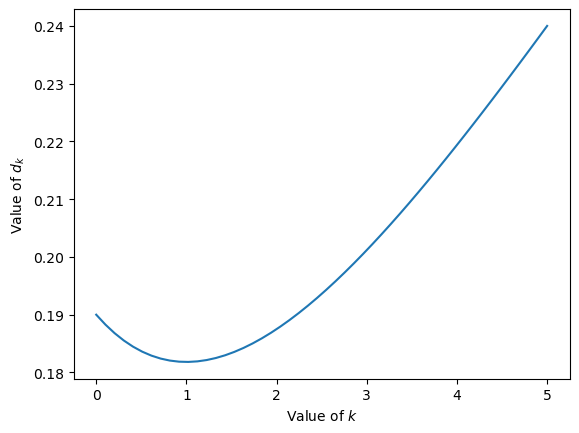

In [12]:
N = 10 # Arbitrary: number of samples
k = np.linspace(0,5,50)
dk = (2 * (N-1) + (k+1)**2)/(N+k)**2
plt.plot(k,dk)
plt.xlabel(r'Value of $k$')
plt.ylabel(r'Value of $d_k$');

So, as desired, we have shown that the mean square deviation from unity is smallest for $d_1$ for all $k$.